# Evaluation

In [3]:
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
from time import time

In [ ]:
combined_df = pd.read_pickle(os.environ['MCMC_WORKDIR'] + "/python/mcmc_runs/diamonds-example-combined.pkl")

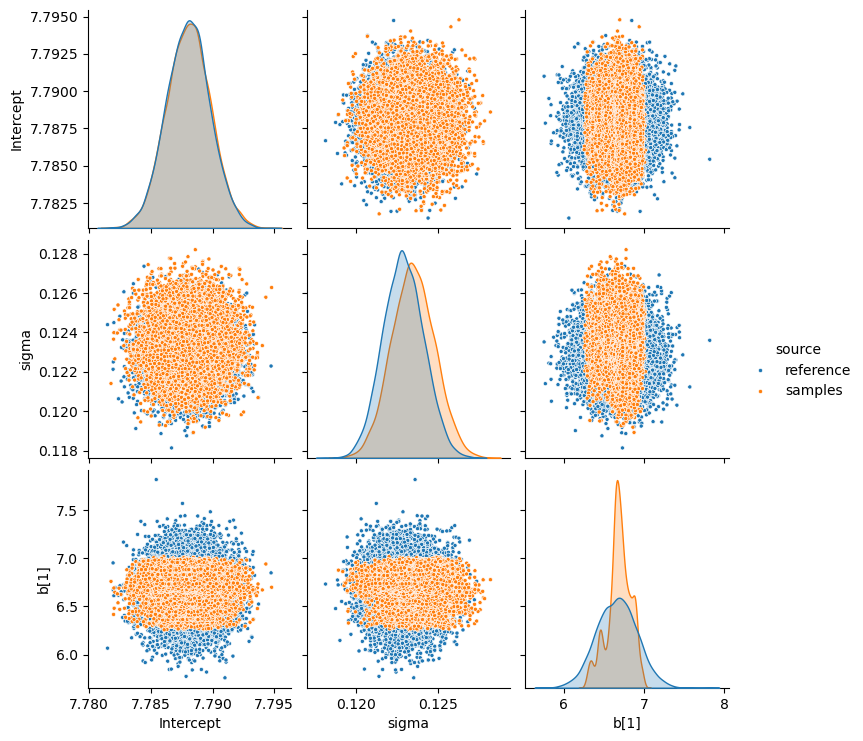

In [5]:
sns.pairplot(combined_df, hue="source", markers=".", vars=["Intercept", "sigma", "b[1]"])

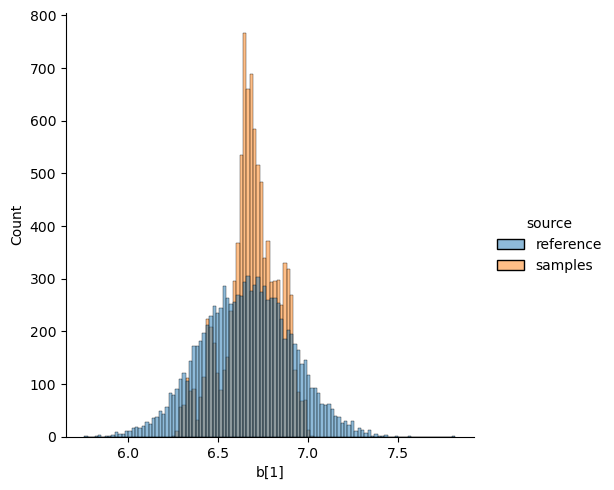

In [6]:
sns.displot(combined_df, x="b[1]", hue="source")

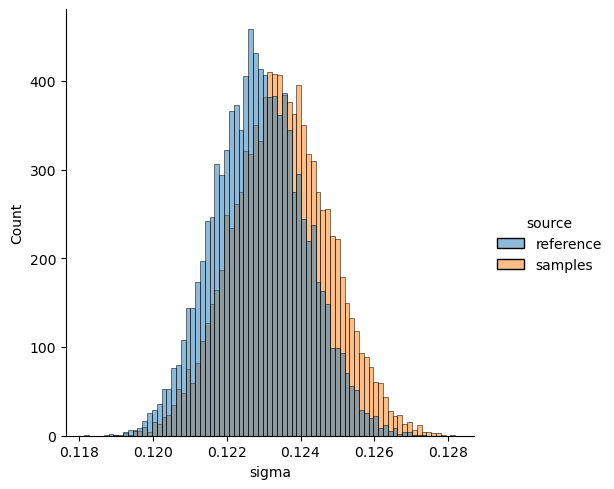

In [7]:
sns.displot(combined_df, x="sigma", hue="source")

In [8]:
references = jnp.array(combined_df.where(combined_df["source"] == "reference").dropna().drop(columns="source"))
samples = jnp.array(combined_df.where(combined_df["source"] == "samples").dropna().drop(columns="source"))

In [9]:
n_max, d_max = references.shape
print(f"n={n_max}, d={d_max}")

n=10000, d=26


## 3.1. Moments

RMSE of sampled moments of interest compared to a reference posterior moments

In [10]:
p = 2

pth_moments = combined_df.groupby("source").aggregate(lambda vals: sum(vals**p)/len(vals)).transpose().rename_axis(f"E[|X|^{p}]")
pth_moments["diff (%)"] = abs(pth_moments["reference"] - pth_moments["samples"])/(pth_moments["reference"])*100

pth_moments

source,reference,samples,diff (%)
E[|X|^2],,,
b[1],44.417422,44.700661,0.637675
b[2],40.598356,29.606578,27.074441
b[3],22.040444,13.948840,36.712526
b[4],2.113180,1.985428,6.045510
b[5],0.018108,0.018292,1.016479
b[6],0.001659,0.001652,0.435336
b[7],0.000552,0.000467,15.397300
b[8],0.000024,0.000020,16.064411
b[9],0.197932,0.198012,0.040199


In [11]:
from evaluation import pth_moment_rmse

In [12]:
%%time
pth_moment_rmse(references, samples).item()

CPU times: user 62.6 ms, sys: 15 ms, total: 77.6 ms
Wall time: 41.1 ms


3.4000627994537354

## 3.2. Wasserstein-1 Distance

$$ \mathcal{W}(u, v) = \inf_{\xi \in \mathcal{C} (u, v)} \int \| x-y \|_2 \xi (dx,dy) $$

For discrete disctrbutions
$$ \widehat{u}_n = \sum_{i=1}^n \delta_{x_i} \mathbf{u}_i, \quad \widehat{v}_m = \sum_{j=1}^m \delta_{y_j} \mathbf{v}_j $$
the following LP problem needs to be solved:

$$ \mathcal{W}(\widehat{u}_n, \widehat{v}_m) = \min_{P \in U (\mathbf{u}, \mathbf{v})} \sum_{i,j} P_{ij} \cdot C_{ij} = \min_{P \in U (\mathbf{u}, \mathbf{v})} \left< P, C \right>, $$ 
where: 
$$ C_{ij} := \| x_i - y_j \|_2 $$ is cost matrix, 
$$ U(u, v) :=  \{ P \in \mathbb{R}^{n \times m}_{+} \mid P \mathbb{1}_m = \mathbf{u} , P^T \mathbb{1}_n = \mathbf{v} \}$$ is the set of all couplings (convex polytope)

If we take $n=m$ and assume  $(x_i, y_i)_{i=1}^n$ are i.i.d. samples from $u$ and $v$, then for $d>2$ it holds:

$$
\mathbb{E}\left[ \left\vert \mathcal{W}(\widehat{u}_n, \widehat{v}_n) - \mathcal{W}(u, v) \right\vert \right] = O(n^{-1/d})
$$

In [13]:
from utils.evaluation import wasserstein_scipy, wasserstein_dist11_p, wasserstein_sinkhorn, max_sliced_wasserstein

x = references[-1000:, -10:]
y = samples[-1000:, -10:]

x.shape, y.shape

((1000, 10), (1000, 10))

### 3.2.0. The slowest
solves the LP, useful for the case when $n \neq m$ and there are weights

In [14]:
# %%time

# wasserstein_scipy(x, y)

CPU times: user 2min 11s, sys: 1.66 s, total: 2min 13s

Wall time: 2min 13s

0.4365652607663276



### 3.2.1. Optimal 1-1 coupling

If $n=m$, and $\mathbf{u} = \mathbf{v}$, the 
then the vertices of the polytope are 1-1 couplings, and hence we don't need to explore the whole space.

The problem is solved by the Hungarian algorithm in $O(n^3)$

In [84]:
%%time
wasserstein_dist11_p(x, y)

CPU times: user 288 ms, sys: 7.26 ms, total: 295 ms
Wall time: 296 ms


0.4365652607663286

### 3.2.1. Sinkhorn's algorithm 

solves the regularized problem $$ \min_{P \in U (\mathbf{u}, \mathbf{u})} \left< P, C \right> -\varepsilon H(P), $$
with entropy $H(P)$ defined as
$$H(P) := - \sum_{i,j} P_{ij} (\log P_{ij} -1).$$
By setting $ \varepsilon = \frac{4 \log n}{\tau}  $, Sinkhorn computes a $ \tau $-approximate solution of the unregularized  problem in $O(n^2 \log n \tau^{-3})$ operations 

In [86]:
%%time

wasserstein_sinkhorn(x, y)

CPU times: user 379 ms, sys: 17.7 ms, total: 397 ms
Wall time: 205 ms


0.2400493174791336

In [87]:
%%time

wasserstein_sinkhorn(x, y, epsilon=1e-2)

CPU times: user 490 ms, sys: 15.1 ms, total: 505 ms
Wall time: 273 ms


0.3177565336227417

In [88]:
%%time

wasserstein_sinkhorn(x, y, epsilon=1e-3)

CPU times: user 4.84 s, sys: 104 ms, total: 4.94 s
Wall time: 2.74 s


0.4266848564147949

In [89]:
%%time

wasserstein_sinkhorn(x, y, epsilon=1e-4)

CPU times: user 9.6 s, sys: 227 ms, total: 9.83 s
Wall time: 5.43 s


0.413084477186203

### 3.2.3. Max-sliced Wasserstein

In [20]:
%%time

rng_key = random.PRNGKey(0)
max_sliced_wasserstein(x, y, rng_key, n_directions=10000).item()

CPU times: user 3.32 s, sys: 91.5 ms, total: 3.41 s
Wall time: 3.24 s


0.37519899010658264

In [102]:
def run_algo(x, y, algo):
    if algo == "hungarian":
        algo_func = lambda x, y: wasserstein_dist11_p(x, y)
    elif algo == "sinkhorn":
        algo_func = lambda x, y: wasserstein_sinkhorn(x, y)
    elif algo == "sinkhorn_eps1e-2":
        algo_func = lambda x, y: wasserstein_sinkhorn(x, y, epsilon=1e-2)
    elif algo == "sinkhorn_eps1e-3":
        algo_func = lambda x, y: wasserstein_sinkhorn(x, y, epsilon=1e-3)
    elif algo == "sinkhorn_eps1e-4":
        algo_func = lambda x, y: wasserstein_sinkhorn(x, y, epsilon=1e-4)
    elif algo == "max_sliced_dir100":
        algo_func = lambda x, y: max_sliced_wasserstein(x, y, random.PRNGKey(0), n_directions=100).item()
    elif algo == "max_sliced_dir10000":
        algo_func = lambda x, y: max_sliced_wasserstein(x, y, random.PRNGKey(0), n_directions=10000).item()
        
    start = time()
    dist = algo_func(x, y)
    runtime = time() - start
    
    return dist, runtime

In [108]:
%%time

algo_data = {"algo": [], "n": [], "d": [], "dist": [], "runtime": [], }

for algo in ["hungarian", "sinkhorn_eps1e-2", "sinkhorn_eps1e-3", "sinkhorn_eps1e-4","max_sliced_dir100", "max_sliced_dir10000"]:
    for d in [5, 10, 25]:
        for n in [30, 100, 300, 1000]: #, 3000, 10000]:
            x = references[-n:, -d:]
            y = samples[-n:, -d:]
        
            dist, runtime = run_algo(x, y, algo)
        
            algo_data["n"].append(n)
            algo_data["d"].append(d)
            algo_data["algo"].append(algo)
            algo_data["dist"].append(dist)
            algo_data["runtime"].append(runtime)

CPU times: user 1min 3s, sys: 1.51 s, total: 1min 5s
Wall time: 43.2 s


In [123]:
algo_data_pd = pd.read_pickle("wasserstein_comparison.pkl")
# algo_data_pd = pd.DataFrame(algo_data)


In [124]:
true_dist = algo_data_pd[algo_data_pd["algo"] == "hungarian"][["n", "d", "dist"]].set_index(["n", "d"])
algo_data_pd = algo_data_pd.join(true_dist, on=["n", "d"], how="left", rsuffix="_true", validate="many_to_one")
algo_data_pd["rel_dist"] = (algo_data_pd["dist"]) / algo_data_pd["dist_true"]

algo_data_pd

,algo,n,d,dist,runtime,dist_true,rel_dist
0,hungarian,30,5,0.596279,0.000129,0.596279,1.000000
1,hungarian,100,5,0.615183,0.001061,0.615183,1.000000
2,hungarian,300,5,0.546191,0.014939,0.546191,1.000000
3,hungarian,1000,5,0.436049,0.281208,0.436049,1.000000
4,hungarian,3000,5,0.196930,3.571876,0.196930,1.000000
...,...,...,...,...,...,...,...
103,max_sliced_dir10000,100,25,0.898660,0.321008,1.346228,0.667539
104,max_sliced_dir10000,300,25,0.749701,0.869446,1.141987,0.656488
105,max_sliced_dir10000,1000,25,0.470302,2.928719,0.752067,0.625346
106,max_sliced_dir10000,3000,25,0.252116,9.141102,0.423300,0.595596


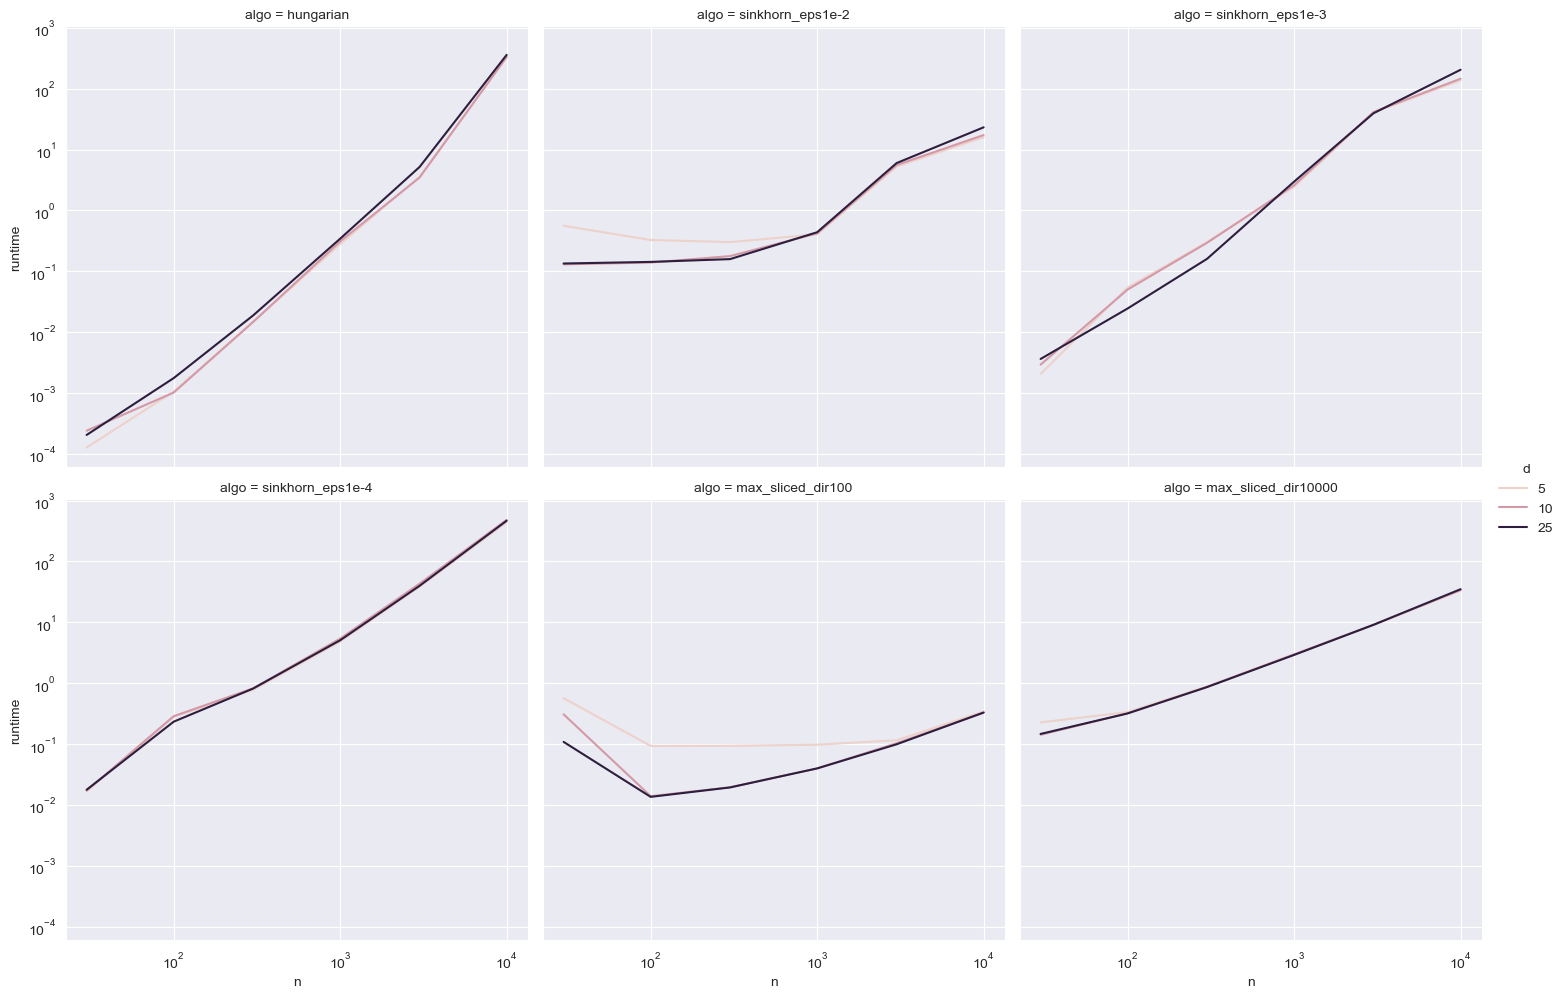

In [125]:
sns.relplot(
    algo_data_pd, 
    x="n", 
    y="runtime", 
    hue="d", 
    col="algo", 
    kind="line", 
    col_wrap=3, 
).set(xscale="log", yscale="log")

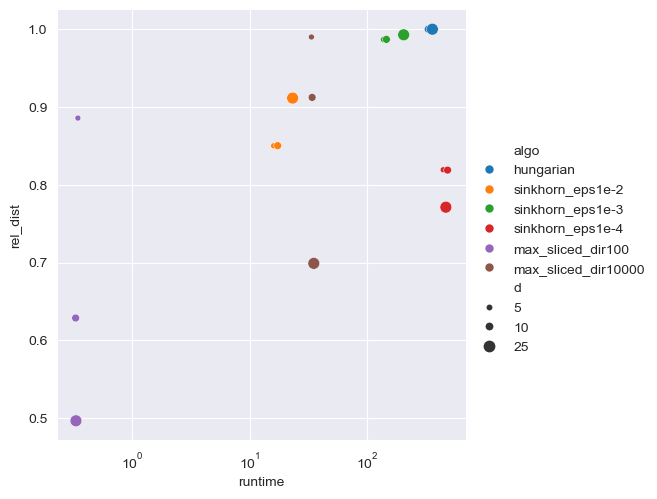

In [131]:
sns.relplot(
    algo_data_pd[(algo_data_pd["n"] == algo_data_pd["n"].max())], 
    x="runtime", y="rel_dist", hue="algo", size="d", 
).set(xscale="log")

In [95]:
from IPython.display import Image
Image(url="https://ott-jax.readthedocs.io/en/latest/_images/6364ce920f01ca5e8216295660ed76a4b05db543dfc88acac832e728789f4d34.png")

## 3.3. Maximum Mean Discrepancy

Given a symmetric, positive-definite kernel kernel $k(\cdot,\cdot): \mathcal{X} \times \mathcal{X} \to \mathbb{R}$,
the MMD between distributions $P$ and $Q$ is given by

$$ MMD(P, Q)^2 = \int_{\mathcal{X} \times \mathcal{X}} k(x, x') P(dx)P(dx') + \int_{\mathcal{X} \times \mathcal{X}} k(y, y') Q(dy)Q(dy') - 2\int_{\mathcal{X} \times \mathcal{X}} k(x, y) P(dx)Q(dy) $$

Unbiased estimator:

$$ MMD(\widehat{P}_n, \widehat{Q}_m)^2 = \frac{1}{n(n-1)}\sum_{i \neq i'}k(x_i, x_{i'}) + \frac{1}{m(m-1)}\sum_{j \neq j'}k(y_j, y_{j'}) - \frac{2}{mn}\sum_{i, j}k(x_i, y_j) $$

Usually Gaussian kernel is used with

$$ k(x,y) := \exp \left( -\gamma \| x-y \|^2 \right) $$.


In [120]:
from utils.evaluation import mmd2_unbiased

In [122]:
%%time
mmd2_unbiased(samples, references).item()

CPU times: user 3.92 s, sys: 92.8 ms, total: 4.02 s
Wall time: 938 ms


0.32471024990081787